In [15]:
!git clone -b reduce_features https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


In [16]:
# Cell 1: Imports & Paths
import os
import math
import json
import random
from pathlib import Path
from collections import Counter
from dataclasses import dataclass, asdict
from typing import Optional, Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Required paths (as given)
PROJECT_ROOT = Path('/content/ann-visual-emotion')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL   = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST  = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
DATA_DIR  = PROJECT_ROOT / 'data/raw/EmoSet'

print("Project root:", PROJECT_ROOT)

# Quick existence check
for p in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH, DATA_DIR]:
    print(f"{p}: {'OK' if p.exists() else 'MISSING'}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Project root: /content/ann-visual-emotion
/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json: OK
/content/ann-visual-emotion/data/raw/EmoSet: OK
Device: cuda


In [17]:
# Cell 2: Config & Toggles

@dataclass
class TrainConfig:
    image_col: str = "filepath"
    label_col: str = "label"
    out_dir: str = "artifacts"
    backbone: str = "resnet18"          # 'resnet18', 'resnet34', 'resnet50'
    arcface: bool = False               # Use ArcFace margin head
    arc_s: float = 30.0
    arc_m: float = 0.30
    batch_size: int = 32
    epochs: int = 60
    patience: int = 8
    warmup_epochs: int = 3
    base_backbone_lr: float = 1e-4
    head_lr: float = 1e-3
    weight_decay: float = 1e-4
    label_smoothing: float = 0.05
    use_mixup: bool = True
    mixup_alpha: float = 0.4
    use_cutmix: bool = False
    cutmix_alpha: float = 1.0
    switch_sharpen_epochs: int = 7   # last N epochs -> disable mixup/smoothing
    focal_last_phase: bool = False   # switch to FocalLoss late
    focal_gamma: float = 2.0
    use_ema: bool = True
    ema_decay: float = 0.999
    img_size: int = 224
    progressive_resize: bool = False
    progressive_target: int = 256
    progressive_start: int = 45
    use_weighted_sampler: bool = False
    save_metric: str = "macro_f1"    # or "acc"
    seed: int = 42

cfg = TrainConfig()
print(cfg)

TrainConfig(image_col='filepath', label_col='label', out_dir='artifacts', backbone='resnet18', arcface=False, arc_s=30.0, arc_m=0.3, batch_size=32, epochs=60, patience=8, warmup_epochs=3, base_backbone_lr=0.0001, head_lr=0.001, weight_decay=0.0001, label_smoothing=0.05, use_mixup=True, mixup_alpha=0.4, use_cutmix=False, cutmix_alpha=1.0, switch_sharpen_epochs=7, focal_last_phase=False, focal_gamma=2.0, use_ema=True, ema_decay=0.999, img_size=224, progressive_resize=False, progressive_target=256, progressive_start=45, use_weighted_sampler=False, save_metric='macro_f1', seed=42)


In [18]:
# Cell 3: Load DataFrames & Label Map

train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

def load_label_map(path: Path, df: pd.DataFrame, label_col: str):
    if path.exists():
        with open(path, 'r') as f:
            lm = json.load(f)
        if isinstance(lm, dict):
            if all(isinstance(v, int) for v in lm.values()):
                label_to_id = lm
            else:
                label_to_id = {v: int(k) for k, v in lm.items()}
        elif isinstance(lm, list):
            label_to_id = {lbl: i for i, lbl in enumerate(lm)}
        else:
            raise ValueError("Unsupported label_map format.")
    else:
        unique = sorted(df[label_col].unique())
        label_to_id = {lbl: i for i, lbl in enumerate(unique)}
    classes = [lbl for lbl, _id in sorted(label_to_id.items(), key=lambda x: x[1])]
    return classes, label_to_id

CLASSES, class_to_idx = load_label_map(LABEL_MAP_PATH, train_df, cfg.label_col)
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES)
print("Train size:", len(train_df), "Val size:", len(val_df), "Test size:", len(test_df))

Classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']
Train size: 20150 Val size: 4030 Test size: 1005


In [19]:
# Cell 4: Transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def build_transforms(img_size=224, strong=True):
    if strong:
        train_tf = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(0.25, 0.25, 0.25, 0.10),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), value='random')
        ])
    else:
        train_tf = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size * 1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
    return train_tf, val_tf

train_tf, val_tf = build_transforms(cfg.img_size, strong=True)

In [20]:
# Cell 5: Dataset Class

class EmotionDataset(Dataset):
    def __init__(self, df, image_col, label_col, class_to_idx, transform=None, data_root=None):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.data_root = Path(data_root) if data_root else None

    def resolve_path(self, raw):
        p = Path(raw)
        if p.is_absolute() and p.exists(): return p
        if self.data_root:
            candidate = self.data_root / p
            if candidate.exists(): return candidate
        if p.exists(): return p
        raise FileNotFoundError(f"Image not found: {raw}")

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = self.resolve_path(row[self.image_col])
        label_name = row[self.label_col]
        label = self.class_to_idx[label_name]
        with Image.open(img_path) as img:
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [21]:
# Cell 6: Build Datasets & DataLoaders

train_dataset = EmotionDataset(train_df, cfg.image_col, cfg.label_col,
                               class_to_idx, transform=train_tf, data_root=DATA_DIR)
val_dataset = EmotionDataset(val_df, cfg.image_col, cfg.label_col,
                             class_to_idx, transform=val_tf, data_root=DATA_DIR)
test_dataset = EmotionDataset(test_df, cfg.image_col, cfg.label_col,
                              class_to_idx, transform=val_tf, data_root=DATA_DIR)

if cfg.use_weighted_sampler:
    counts = Counter(train_df[cfg.label_col])
    inv = {lbl: 1.0 / c for lbl, c in counts.items()}
    sample_weights = train_df[cfg.label_col].map(inv).values
    sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights),
                                    num_samples=len(sample_weights),
                                    replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size,
                              sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size,
                              shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size,
                         shuffle=False, num_workers=2, pin_memory=True)

print("Loaders ready.")

Loaders ready.


In [22]:
# Cell 7: Mixup / CutMix helpers

def apply_mixup(x, y, alpha=0.4):
    if alpha <= 0:
        return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, (y, y[idx], lam), True

def apply_cutmix(x, y, alpha=1.0):
    if alpha <= 0:
        return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = x.size()
    idx = torch.randperm(B, device=x.device)
    rx, ry = np.random.randint(W), np.random.randint(H)
    rw = int(W * math.sqrt(1 - lam))
    rh = int(H * math.sqrt(1 - lam))
    x1 = np.clip(rx - rw//2, 0, W)
    y1 = np.clip(ry - rh//2, 0, H)
    x2 = np.clip(rx + rw//2, 0, W)
    y2 = np.clip(ry + rh//2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adjust = 1 - ((x2 - x1)*(y2 - y1)/(W*H))
    return x, (y, y[idx], lam_adjust), True

In [23]:
# Cell 8: Focal Loss & ArcFace

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        if alpha is not None:
            self.alpha = torch.tensor(alpha)
        else:
            self.alpha = None
        self.reduction = reduction

    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits, targets,
            reduction='none',
            weight=self.alpha.to(logits.device) if self.alpha is not None else None
        )
        pt = torch.exp(-ce)
        loss = (1 - pt) ** self.gamma * ce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.30, easy_margin=False):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, emb, labels):
        W = F.normalize(self.weight)
        X = F.normalize(emb)
        cosine = F.linear(X, W)
        sine = torch.sqrt(torch.clamp(1.0 - cosine**2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1,1), 1.0)
        logits = (one_hot * phi) + ((1 - one_hot) * cosine)
        return logits * self.s

In [24]:
# Cell 9: Model & Discriminative LR

class EmotionModel(nn.Module):
    def __init__(self, num_classes, backbone='resnet18',
                 arcface=False, arc_s=30.0, arc_m=0.30, dropout=0.25):
        super().__init__()
        self.arcface = arcface
        if backbone == 'resnet18':
            net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        elif backbone == 'resnet34':
            net = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        elif backbone == 'resnet50':
            net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        else:
            raise ValueError("Unsupported backbone")

        feat_dim = net.fc.in_features
        self.features = nn.Sequential(*list(net.children())[:-1])

        if arcface:
            self.embedding = nn.Sequential(
                nn.Linear(feat_dim, 512),
                nn.ReLU(inplace=True),
                nn.LayerNorm(512),
                nn.Dropout(dropout)
            )
            self.arc = ArcMarginProduct(512, num_classes, s=arc_s, m=arc_m)
        else:
            self.classifier = nn.Sequential(
                nn.Linear(feat_dim, 512),
                nn.ReLU(inplace=True),
                nn.LayerNorm(512),
                nn.Dropout(dropout),
                nn.Linear(512, num_classes)
            )

    def forward(self, x, labels=None):
        x = self.features(x)
        x = torch.flatten(x, 1)
        if self.arcface:
            emb = self.embedding(x)
            if labels is None:
                raise ValueError("ArcFace requires labels in forward")
            return self.arc(emb, labels)
        else:
            return self.classifier(x)

def make_param_groups(model, base_backbone_lr, head_lr, arcface=False):
    # features: [0 conv,1 bn,2 relu,3 pool,4 l1,5 l2,6 l3,7 l4,8 avgpool]
    groups = []
    layer_map = {
        "early": [model.features[0], model.features[1]],
        "layer1": [model.features[4]],
        "layer2": [model.features[5]],
        "layer3": [model.features[6]],
        "layer4": [model.features[7]],
    }
    scale = {"early": 0.5, "layer1":0.5, "layer2":1.0, "layer3":1.0, "layer4":2.0}
    for name, mods in layer_map.items():
        params = []
        for m in mods:
            for p in m.parameters():
                if p.requires_grad:
                    params.append(p)
        if params:
            groups.append({"params": params, "lr": base_backbone_lr * scale[name]})
    head_params = []
    if arcface:
        head_params += list(model.embedding.parameters()) + list(model.arc.parameters())
    else:
        head_params += list(model.classifier.parameters())
    groups.append({"params": head_params, "lr": head_lr})
    return groups

In [25]:
# Cell 10: EMA

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()

    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1 - self.decay)

    def apply(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                p.data.copy_(self.shadow[n])

In [26]:
# Cell 11: Train & Evaluate

def train_one_epoch(model, loader, optimizer, device, criterion, scaler=None,
                    use_mixup=False, mixup_alpha=0.4,
                    use_cutmix=False, cutmix_alpha=1.0,
                    arcface=False, ema: Optional[EMA]=None):
    model.train()
    total_loss, total_correct, total = 0.0, 0.0, 0

    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        mixed = False
        if use_mixup and use_cutmix:
            if random.random() < 0.5:
                imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, mixup_alpha)
            else:
                imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cutmix_alpha)
        elif use_mixup:
            imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, mixup_alpha)
        elif use_cutmix:
            imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cutmix_alpha)

        with autocast(enabled=(scaler is not None)):
            if arcface:
                if mixed:
                    logits = model(imgs, ya)
                    loss = lam * criterion(logits, ya) + (1 - lam)*criterion(logits, yb)
                else:
                    logits = model(imgs, labels)
                    loss = criterion(logits, labels)
            else:
                logits = model(imgs)  # standard head ignoring labels in fwd
                if mixed:
                    loss = lam * criterion(logits, ya) + (1 - lam)*criterion(logits, yb)
                else:
                    loss = criterion(logits, labels)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if ema:
            ema.update(model)

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        with torch.no_grad():
            preds = logits.argmax(1)
            if mixed:
                total_correct += (lam * preds.eq(ya).sum().item() +
                                  (1 - lam) * preds.eq(yb).sum().item())
            else:
                total_correct += preds.eq(labels).sum().item()
            total += bs

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate(model, loader, device, criterion, arcface=False):
    model.eval()
    total_loss, total_correct, total = 0.0, 0.0, 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        if arcface:
            logits = model(imgs, labels)
        else:
            logits = model(imgs)
        loss = criterion(logits, labels)
        bs = imgs.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(1)
        total_correct += preds.eq(labels).sum().item()
        total += bs
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    return total_loss / total, acc, macro_f1, all_preds, all_labels

In [27]:
# Cell 12: Scheduler Helper

def cosine_warmup(epoch, total_epochs, warmup_epochs):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
    return 0.5 * (1 + math.cos(math.pi * progress))

In [28]:
# Cell 13: Initialize Objects

model = EmotionModel(NUM_CLASSES,
                     backbone=cfg.backbone,
                     arcface=cfg.arcface,
                     arc_s=cfg.arc_s,
                     arc_m=cfg.arc_m).to(device)

param_groups = make_param_groups(model,
                                 cfg.base_backbone_lr,
                                 cfg.head_lr,
                                 arcface=cfg.arcface)

optimizer = torch.optim.Adam(param_groups, weight_decay=cfg.weight_decay)
scaler = GradScaler(enabled=(device.type == "cuda"))

criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
ema = EMA(model, decay=cfg.ema_decay) if cfg.use_ema else None

class EarlyStopper:
    def __init__(self, patience=8, mode='max', min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.bad = 0
        self.stop = False
    def step(self, val):
        if self.best is None:
            self.best = val
            return False
        improve = (val - self.best) if self.mode == 'max' else (self.best - val)
        if self.mode == 'max':
            if improve > self.min_delta:
                self.best = val
                self.bad = 0
            else:
                self.bad += 1
        else:
            if improve > self.min_delta:
                self.best = val
                self.bad = 0
            else:
                self.bad += 1
        if self.bad >= self.patience:
            self.stop = True
        return self.stop

early_stopper = EarlyStopper(patience=cfg.patience, mode='max')

history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": [], "val_macro_f1": []
}

print("Model initialized.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Model initialized.


/tmp/ipython-input-211188417.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


In [29]:
# Cell 14: Training Loop

best_metric = -1
best_state = None
use_mixup = cfg.use_mixup
use_cutmix = cfg.use_cutmix
sharpen_epoch = cfg.epochs - cfg.switch_sharpen_epochs

for epoch in range(cfg.epochs):
    # Progressive resize trigger
    if cfg.progressive_resize and epoch == cfg.progressive_start:
        new_size = cfg.progressive_target
        train_tf, val_tf = build_transforms(new_size, strong=True)
        train_dataset.transform = train_tf
        val_dataset.transform = val_tf
        test_dataset.transform = val_tf
        print(f"[Epoch {epoch}] Progressive resize -> {new_size}")

    # Late phase switch (sharpen)
    if epoch == sharpen_epoch:
        print(f"[Epoch {epoch}] Switching to sharpen phase")
        use_mixup = False
        use_cutmix = False
        if cfg.focal_last_phase:
            print("Switching to FocalLoss")
            criterion = FocalLoss(gamma=cfg.focal_gamma)
        else:
            print("Removing label smoothing")
            criterion = nn.CrossEntropyLoss()
        # reduce LR
        for g in optimizer.param_groups:
            g['lr'] *= 0.2

    # Warmup + cosine scaling (manual)
    scale = cosine_warmup(epoch, cfg.epochs, cfg.warmup_epochs)
    if epoch < cfg.warmup_epochs:
        # Already adjusting base groups by scale each epoch start
        for g in optimizer.param_groups:
            base_lr = g.get('initial_lr', g['lr'])
            g['initial_lr'] = base_lr  # store
            g['lr'] = base_lr * scale

    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, device, criterion, scaler,
        use_mixup=use_mixup, mixup_alpha=cfg.mixup_alpha,
        use_cutmix=use_cutmix, cutmix_alpha=cfg.cutmix_alpha,
        arcface=cfg.arcface, ema=ema
    )

    val_loss, val_acc, val_macro_f1, val_preds, val_targets = evaluate(
        model, val_loader, device, criterion, arcface=cfg.arcface
    )

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_macro_f1"].append(val_macro_f1)

    if cfg.save_metric == "macro_f1":
        metric_now = val_macro_f1
    else:
        metric_now = val_acc

    print(f"Epoch {epoch+1}/{cfg.epochs} "
          f"TrainLoss {train_loss:.4f} Acc {train_acc:.4f} | "
          f"ValLoss {val_loss:.4f} Acc {val_acc:.4f} MacroF1 {val_macro_f1:.4f}")

    if metric_now > best_metric:
        best_metric = metric_now
        best_state = {
            "model": model.state_dict(),
            "epoch": epoch,
            "val_metric": best_metric,
            "config": asdict(cfg)
        }
        ART_DIR = (PROJECT_ROOT / cfg.out_dir)
        ART_DIR.mkdir(parents=True, exist_ok=True)
        torch.save(best_state, ART_DIR / "best_model_checkpoint.pth")

    if early_stopper.step(metric_now):
        print("Early stopping triggered.")
        break

print("Best", cfg.save_metric, "=", best_metric)

/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 1/60 TrainLoss 1.3230 Acc 0.4774 | ValLoss 0.9975 Acc 0.6566 MacroF1 0.6553


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 2/60 TrainLoss 1.1829 Acc 0.5641 | ValLoss 0.8969 Acc 0.6953 MacroF1 0.6949


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 3/60 TrainLoss 1.1542 Acc 0.5867 | ValLoss 0.9064 Acc 0.6864 MacroF1 0.6858


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 4/60 TrainLoss 1.1136 Acc 0.6096 | ValLoss 0.8775 Acc 0.7206 MacroF1 0.7211


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 5/60 TrainLoss 1.0816 Acc 0.6271 | ValLoss 0.8890 Acc 0.7087 MacroF1 0.7110


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 6/60 TrainLoss 1.0704 Acc 0.6333 | ValLoss 0.8796 Acc 0.7189 MacroF1 0.7173


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 7/60 TrainLoss 1.0681 Acc 0.6316 | ValLoss 0.8375 Acc 0.7256 MacroF1 0.7248


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 8/60 TrainLoss 1.0273 Acc 0.6543 | ValLoss 0.8453 Acc 0.7213 MacroF1 0.7203


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 9/60 TrainLoss 1.0168 Acc 0.6553 | ValLoss 0.8450 Acc 0.7409 MacroF1 0.7398


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 10/60 TrainLoss 1.0144 Acc 0.6574 | ValLoss 0.8734 Acc 0.7102 MacroF1 0.7130


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 11/60 TrainLoss 0.9855 Acc 0.6735 | ValLoss 0.8321 Acc 0.7340 MacroF1 0.7357


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 12/60 TrainLoss 1.0088 Acc 0.6583 | ValLoss 0.8301 Acc 0.7429 MacroF1 0.7438


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 13/60 TrainLoss 0.9759 Acc 0.6782 | ValLoss 0.8141 Acc 0.7422 MacroF1 0.7435


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 14/60 TrainLoss 0.9822 Acc 0.6741 | ValLoss 0.8351 Acc 0.7424 MacroF1 0.7440


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 15/60 TrainLoss 0.9436 Acc 0.6937 | ValLoss 0.8418 Acc 0.7288 MacroF1 0.7291


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 16/60 TrainLoss 0.9480 Acc 0.6947 | ValLoss 0.8266 Acc 0.7444 MacroF1 0.7440


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 17/60 TrainLoss 0.9456 Acc 0.6948 | ValLoss 0.8535 Acc 0.7365 MacroF1 0.7366


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 18/60 TrainLoss 0.9407 Acc 0.6946 | ValLoss 0.8514 Acc 0.7337 MacroF1 0.7355


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 19/60 TrainLoss 0.9203 Acc 0.7060 | ValLoss 0.8223 Acc 0.7429 MacroF1 0.7449


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 20/60 TrainLoss 0.9342 Acc 0.7000 | ValLoss 0.8213 Acc 0.7496 MacroF1 0.7491


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 21/60 TrainLoss 0.9068 Acc 0.7156 | ValLoss 0.8501 Acc 0.7395 MacroF1 0.7404


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 22/60 TrainLoss 0.8937 Acc 0.7215 | ValLoss 0.8283 Acc 0.7427 MacroF1 0.7447


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 23/60 TrainLoss 0.8999 Acc 0.7197 | ValLoss 0.8478 Acc 0.7449 MacroF1 0.7466


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 24/60 TrainLoss 0.9079 Acc 0.7148 | ValLoss 0.8271 Acc 0.7496 MacroF1 0.7486


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 25/60 TrainLoss 0.8817 Acc 0.7269 | ValLoss 0.8308 Acc 0.7494 MacroF1 0.7501


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 26/60 TrainLoss 0.8900 Acc 0.7244 | ValLoss 0.8507 Acc 0.7392 MacroF1 0.7403


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 27/60 TrainLoss 0.8697 Acc 0.7351 | ValLoss 0.8213 Acc 0.7404 MacroF1 0.7384


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 28/60 TrainLoss 0.8766 Acc 0.7299 | ValLoss 0.8282 Acc 0.7432 MacroF1 0.7428


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 29/60 TrainLoss 0.8853 Acc 0.7238 | ValLoss 0.8439 Acc 0.7397 MacroF1 0.7394


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 30/60 TrainLoss 0.8552 Acc 0.7431 | ValLoss 0.8101 Acc 0.7509 MacroF1 0.7512


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 31/60 TrainLoss 0.8636 Acc 0.7353 | ValLoss 0.8271 Acc 0.7429 MacroF1 0.7411


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 32/60 TrainLoss 0.8391 Acc 0.7488 | ValLoss 0.8305 Acc 0.7365 MacroF1 0.7377


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 33/60 TrainLoss 0.8475 Acc 0.7464 | ValLoss 0.8190 Acc 0.7494 MacroF1 0.7506


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 34/60 TrainLoss 0.8407 Acc 0.7492 | ValLoss 0.8637 Acc 0.7305 MacroF1 0.7316


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 35/60 TrainLoss 0.8514 Acc 0.7449 | ValLoss 0.8319 Acc 0.7390 MacroF1 0.7402


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 36/60 TrainLoss 0.8420 Acc 0.7502 | ValLoss 0.8221 Acc 0.7563 MacroF1 0.7560


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 37/60 TrainLoss 0.8483 Acc 0.7461 | ValLoss 0.8356 Acc 0.7400 MacroF1 0.7394


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 38/60 TrainLoss 0.8265 Acc 0.7561 | ValLoss 0.8337 Acc 0.7459 MacroF1 0.7440


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 39/60 TrainLoss 0.8121 Acc 0.7647 | ValLoss 0.8421 Acc 0.7457 MacroF1 0.7462


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 40/60 TrainLoss 0.8212 Acc 0.7579 | ValLoss 0.8281 Acc 0.7476 MacroF1 0.7485


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 41/60 TrainLoss 0.8386 Acc 0.7517 | ValLoss 0.8451 Acc 0.7474 MacroF1 0.7484


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 42/60 TrainLoss 0.8271 Acc 0.7558 | ValLoss 0.8609 Acc 0.7414 MacroF1 0.7439


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 43/60 TrainLoss 0.8125 Acc 0.7615 | ValLoss 0.8354 Acc 0.7414 MacroF1 0.7433


/tmp/ipython-input-3277605883.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):


Epoch 44/60 TrainLoss 0.8098 Acc 0.7646 | ValLoss 0.8341 Acc 0.7531 MacroF1 0.7519
Early stopping triggered.
Best macro_f1 = 0.756012536434967


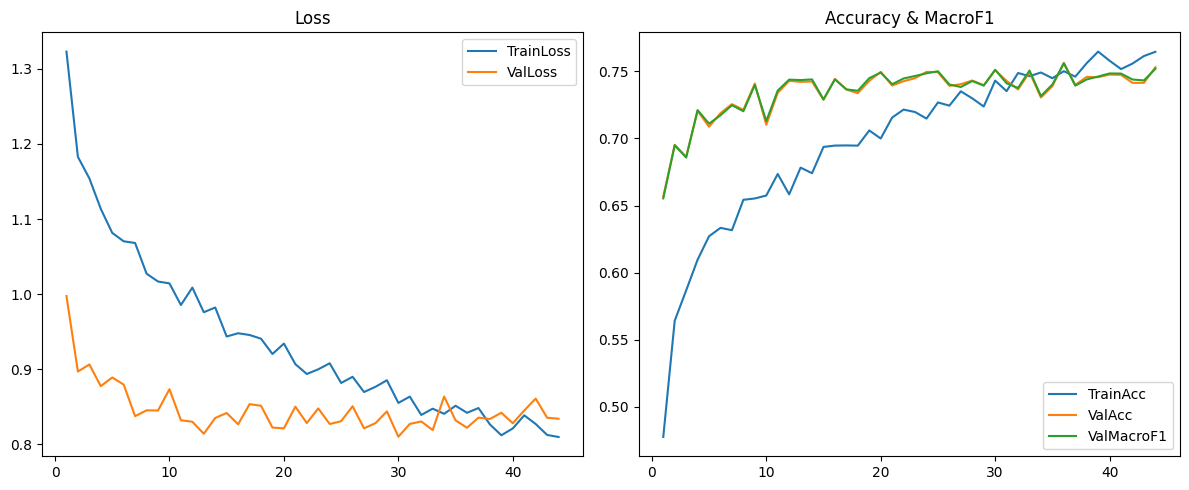

In [30]:
# Cell 15: Plot Curves

epochs_r = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_r, history["train_loss"], label='TrainLoss')
plt.plot(epochs_r, history["val_loss"], label='ValLoss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(epochs_r, history["train_acc"], label='TrainAcc')
plt.plot(epochs_r, history["val_acc"], label='ValAcc')
plt.plot(epochs_r, history["val_macro_f1"], label='ValMacroF1')
plt.legend(); plt.title("Accuracy & MacroF1")
plt.tight_layout()
plt.show()

Loaded best model from epoch 35
Test Loss 0.8071 Acc 0.7592 MacroF1 0.7582

Classification Report:
              precision    recall  f1-score   support

       angry     0.7363    0.6667    0.6997       201
       happy     0.8578    0.8706    0.8642       201
     neutral     0.6942    0.7114    0.7027       201
         sad     0.6552    0.6617    0.6584       201
    surprise     0.8476    0.8856    0.8662       201

    accuracy                         0.7592      1005
   macro avg     0.7582    0.7592    0.7582      1005
weighted avg     0.7582    0.7592    0.7582      1005



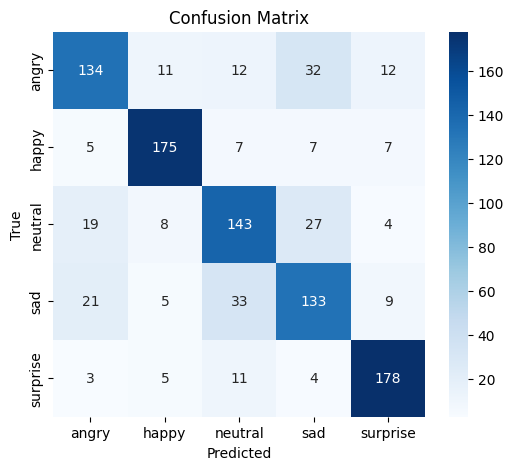

In [31]:
# Cell 16: Test Evaluation

ART_DIR = PROJECT_ROOT / cfg.out_dir
best_ckpt_path = ART_DIR / "best_model_checkpoint.pth"
if best_ckpt_path.exists():
    best_state_loaded = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(best_state_loaded["model"])
    print("Loaded best model from epoch", best_state_loaded["epoch"])
else:
    print("Best checkpoint not found, using current model.")

test_loss, test_acc, test_macro_f1, test_preds, test_targets = evaluate(
    model, test_loader, device, criterion, arcface=cfg.arcface
)
print(f"Test Loss {test_loss:.4f} Acc {test_acc:.4f} MacroF1 {test_macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_targets, test_preds, target_names=CLASSES, digits=4))

cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [32]:
# Cell 17: Save Artifacts

ART_DIR = PROJECT_ROOT / cfg.out_dir
ART_DIR.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), ART_DIR / "final_model.pth")
with open(ART_DIR / "history.json", "w") as f:
    json.dump(history, f, indent=2)

print("Saved:")
print(" -", ART_DIR / "final_model.pth")
print(" -", ART_DIR / "history.json")

Saved:
 - /content/ann-visual-emotion/artifacts/final_model.pth
 - /content/ann-visual-emotion/artifacts/history.json


In [33]:
# Cell 18: TTA Inference Helper

@torch.no_grad()
def predict_tta(pil_img, model=None, transform=None, device=device, arcface=cfg.arcface):
    if model is None:
        model = EmotionModel(NUM_CLASSES,
                             backbone=cfg.backbone,
                             arcface=cfg.arcface,
                             arc_s=cfg.arc_s,
                             arc_m=cfg.arc_m).to(device)
        state = torch.load(PROJECT_ROOT / cfg.out_dir / "best_model_checkpoint.pth", map_location=device)
        model.load_state_dict(state["model"])
        model.eval()

    if transform is None:
        transform = val_tf

    variants = []
    base = transform(pil_img)
    variants.append(base)
    variants.append(torch.flip(base, dims=[2]))  # H-flip

    batch = torch.stack(variants).to(device)
    if arcface:
        dummy = torch.zeros(batch.size(0), dtype=torch.long, device=device)
        logits = model(batch, dummy)
    else:
        logits = model(batch)
    probs = F.softmax(logits, dim=1).mean(0).cpu().numpy()
    return probs

In [34]:
# Cell 19: Single Image Prediction

@torch.no_grad()
def predict_image(img_path: str):
    from PIL import Image
    p = Path(img_path)
    if not p.exists():
        raise FileNotFoundError(p)
    model_local = EmotionModel(NUM_CLASSES,
                               backbone=cfg.backbone,
                               arcface=cfg.arcface,
                               arc_s=cfg.arc_s,
                               arc_m=cfg.arc_m).to(device)
    state = torch.load(PROJECT_ROOT / cfg.out_dir / "best_model_checkpoint.pth", map_location=device)
    model_local.load_state_dict(state["model"])
    model_local.eval()

    with Image.open(p) as img:
        img = img.convert("RGB")
    t = val_tf(img).unsqueeze(0).to(device)
    if cfg.arcface:
        dummy = torch.zeros(1, dtype=torch.long, device=device)
        logits = model_local(t, dummy)
    else:
        logits = model_local(t)
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    pred_idx = probs.argmax()
    return {
        "pred_class": CLASSES[pred_idx],
        "probs": {CLASSES[i]: float(probs[i]) for i in range(len(CLASSES))}
    }

# Example usage (uncomment with a real image path):
# result = predict_image(str(DATA_DIR / 'some_image.jpg'))
# result